# Loading Libraries

In [ ]:
# upload kaggle.json file first !!

! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download 2023-cs155-proj1
! unzip 2023-cs155-proj1.zip

Streaming output truncated to the last 5000 lines.
  inflating: train_csvs/sim_356_26.csv  
  inflating: train_csvs/sim_356_27.csv  
  inflating: train_csvs/sim_356_28.csv  
  inflating: train_csvs/sim_356_29.csv  
  inflating: train_csvs/sim_356_3.csv  
  inflating: train_csvs/sim_356_30.csv  
  inflating: train_csvs/sim_356_31.csv  
  inflating: train_csvs/sim_356_32.csv  
  inflating: train_csvs/sim_356_33.csv  
  inflating: train_csvs/sim_356_34.csv  
  inflating: train_csvs/sim_356_35.csv  
  inflating: train_csvs/sim_356_36.csv  
  inflating: train_csvs/sim_356_37.csv  
  inflating: train_csvs/sim_356_38.csv  
  inflating: train_csvs/sim_356_39.csv  
  inflating: train_csvs/sim_356_4.csv  
  inflating: train_csvs/sim_356_40.csv  
  inflating: train_csvs/sim_356_41.csv  
  inflating: train_csvs/sim_356_42.csv  
  inflating: train_csvs/sim_356_43.csv  
  inflating: train_csvs/sim_356_44.csv  
  inflating: train_csvs/sim_356_45.csv  
  inflating: train_csvs/sim_356_46.csv  
  inflat

In [ ]:
# Basic 

import numpy as np
import pandas as pd
import random
import os
from collections import OrderedDict
from random import shuffle
import os.path as op
from pathlib   import Path
from glob      import glob
from tqdm      import tqdm
from datetime  import datetime
import csv
import json
import os.path as op
from pathlib   import Path
from glob      import glob
from tqdm      import tqdm
from datetime  import datetime

# ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import fbeta_score

# SVM
from sklearn.svm import SVC
from sklearn.metrics import fbeta_score
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance

# RF
from sklearn.ensemble import RandomForestClassifier

# Decision Tree

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# DL

from keras.layers import Dense
from keras.models import Sequential
import tensorflow as tf
from keras.losses import binary_crossentropy, categorical_crossentropy
import keras.backend as K
import numpy as np
from prettytable import PrettyTable
from sklearn.metrics import fbeta_score
from prettytable import ALL

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Sampler, Dataset

np.random.seed(0)

# General Data Processing

## Data Loading

In [ ]:
# Set your target file here #######################

with open('./train.json', 'r') as f:
    track_data = json.load(f)

###################################################


# How many tracks are there?
print(f"n_tracks = {len(track_data.keys())}")

# What do the track Unique IDs (UIDs) look like?
track_uids = list(track_data.keys())
print(f"5 Example Track IDs = {track_uids[:5]}")

# What fields are avaiable for each track?
example_uid = track_uids[0]
print(f"Per-track keys = {track_data[example_uid].keys()}")

# What do the (t, x, y) track coordinates look like?
example_coords = track_data[track_uids[0]]['txy']
example_coords = np.array(example_coords)
np.set_printoptions(threshold=10)
print(f"Coordinate array = \n{example_coords}")

# What does the label look like?
example_label = track_data[track_uids[0]]['label']
print(f"Label = {example_label}")

n_tracks = 16080
5 Example Track IDs = ['lab_0_0', 'lab_0_1', 'lab_0_2', 'lab_0_3', 'lab_0_4']
Per-track keys = dict_keys(['txy', 'label'])
Coordinate array = 
[[  1.    184.166 463.817]
 [  2.    183.941 463.692]
 [  3.    183.716 463.567]
 ...
 [299.    146.777 448.634]
 [300.    146.795 448.518]
 [301.    146.813 448.402]]
Label = 0


## Preliminary Visualization

### Sequence Lengths

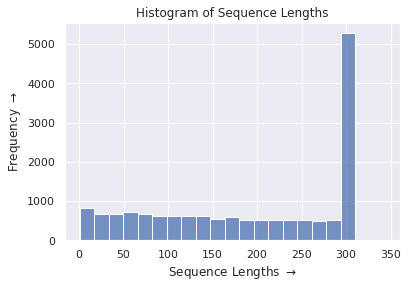

In [ ]:
seq_len = []

for k,v in track_data.items():
    seq_len.append(len(v["txy"]))

sns.histplot(seq_len)
plt.title("Histogram of Sequence Lengths")
plt.ylabel(r"Frequency $\rightarrow$")
plt.xlabel(r"Sequence Lengths $\rightarrow$")
plt.show()


### Tracks

In [ ]:
# Identify unique IDs (UIDs) that are labeled motile and nonmotile
sim_motile_uids = [x for x in track_data.keys() if track_data[x]['label'] == 1 and 'sim' in x]
sim_nonmotile_uids = [x for x in track_data.keys() if track_data[x]['label'] == 0 and 'sim' in x]
lab_motile_uids = [x for x in track_data.keys() if track_data[x]['label'] == 1 and 'lab' in x]
lab_nonmotile_uids = [x for x in track_data.keys() if track_data[x]['label'] == 0 and 'lab' in x]

In [ ]:
def plot_tracks(tracklist, title):
    # plot given tracks
    fig, ax = plt.subplots(figsize=(5,5))
    for t in tracklist:
        ax.plot(t[:,1], t[:,2])
    
    ax.set_xlim([0,1024])
    ax.set_ylim([1024, 0])
    ax.set_aspect(1.0)
    ax.set_title(title)
    
    fig.show()

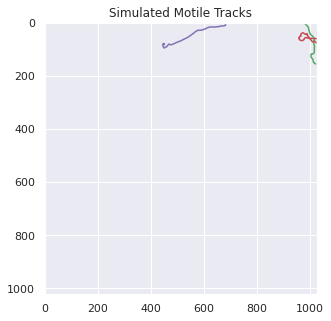

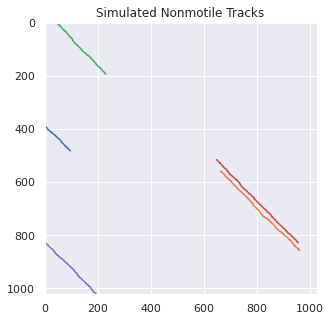

In [ ]:
# Plot 10 simulated motile tracks
plot_uids = random.choices(sim_motile_uids, k=5)
to_plot = [np.array(track_data[u]['txy']) for u in plot_uids]

plot_tracks(to_plot, 'Simulated Motile Tracks')

# Plot 10 simulated nonmotile tracks
plot_uids = random.choices(sim_nonmotile_uids, k=5)
to_plot = [np.array(track_data[u]['txy']) for u in plot_uids]

plot_tracks(to_plot, 'Simulated Nonmotile Tracks')

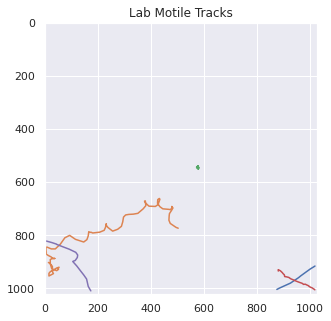

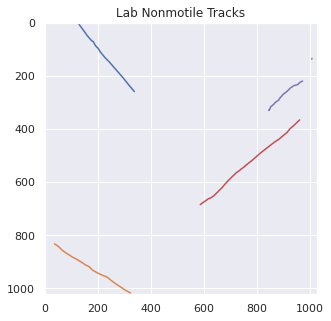

In [ ]:
# Plot 10 lab motile tracks
plot_uids = random.choices(lab_motile_uids, k=5)
to_plot = [np.array(track_data[u]['txy']) for u in plot_uids]

plot_tracks(to_plot, 'Lab Motile Tracks')

# Plot 10 lab nonmotile tracks
plot_uids = random.choices(lab_nonmotile_uids, k=5)
to_plot = [np.array(track_data[u]['txy']) for u in plot_uids]

plot_tracks(to_plot, 'Lab Nonmotile Tracks')

## Feature Defintions (For ML Models)

In [ ]:

def mean_step_speed(coords):
    """Mean step speed of the entire track.
    
    The average per-step speed. Basically the average of distances between points adjacent in time.
    
    Returns
    -------
    float
        The average step speed.
    """

    speeds = []

    for i in range(1, coords.shape[0]):
        # Previous coordinate location
        prev = coords[i-1, 1:]
        # Current coordinate location
        curr = coords[i, 1:]
        
        # Speed in pixels per frame
        curr_speed = np.linalg.norm(curr - prev)
        
        # Accumulate per-step speeds into a list
        speeds.append(curr_speed)
    
    # Return the average of the speeds
    return np.mean(speeds)


def stddev_step_speed(coords):
    """Standard deviation of the step speed of the entire track.
    
    The standard deviation of the per-step speed.
    
    Returns
    -------
    float
        The stddev of the step speed.
    """

    speeds = []

    for i in range(1, coords.shape[0]):
        # Previous coordinate location
        prev = coords[i-1, 1:]
        # Current coordinate location
        curr = coords[i, 1:]
        
        # Speed in pixels per frame
        curr_speed = np.linalg.norm(curr - prev)
        
        # Accumulate per-step speeds into a list
        speeds.append(curr_speed)
    
    # Return the standard deviation of the speeds
    return np.std(speeds)


def track_length(coords):
    """Standard deviation of the step speed of the entire track.
    
    The standard deviation of the per-step speed.
    
    Returns
    -------
    float
        The length of the entire track.
    """

    lengths = []

    for i in range(1, coords.shape[0]):
        # Previous coordinate location
        prev = coords[i-1,1:]
        # Current coordinate location
        curr = coords[i,1:]
        
        # Speed in pixels per frame
        step_length = np.linalg.norm(curr - prev)
        
        # Accumulate per-step speeds into a list
        lengths.append(step_length)
    
    # Return the sum of the lengths
    return np.sum(lengths)


def e2e_distance(coords):
    """End-to-end distance of the track.
    
    The distance from the start and the end of the given track.
    
    Returns
    -------
    float
        The end-to-end distance of the entire track.
    """
    
    # Start and end of the track
    start = coords[0, 1:]
    end = coords[-1, 1:]
    
    # Return the distance
    return np.linalg.norm(end-start)


def duration(coords):
    """Duration of the track.
    
    The time duration of the track.
    
    Returns
    -------
    int
        The end-to-end duration of the entire track.
    """
    
    # Start and end times of the track
    start_t = coords[0, 0]
    end_t = coords[-1, 0]
    
    # Return the difference
    return end_t - start_t

def mean_step_acc(coords):
    """Mean step speed of the entire track.
    
    The average per-step speed. Basically the average of distances between points adjacent in time.
    
    Returns
    -------
    float
        The average step speed.
    """

    speeds = []

    for i in range(1, coords.shape[0]):
        # Previous coordinate location
        prev = coords[i-1, 1:]
        # Current coordinate location
        curr = coords[i, 1:]
        
        # Speed in pixels per frame
        curr_speed = np.linalg.norm(curr - prev)
        
        # Accumulate per-step speeds into a list
        speeds.append(curr_speed)

    acc = [0]

    for i in range(1, len(speeds)):
        # Previous coordinate location
        prev = speeds[i-1]
        # Current coordinate location
        curr = speeds[i]
        
        # Speed in pixels per frame
        curr_acc = np.linalg.norm(curr - prev)
        
        # Accumulate per-step speeds into a list
        acc.append(curr_acc)
    # Return the average of the speeds

    if(speeds == []):
      return float("Nan")
    else:
      return np.mean(acc)

def stddev_step_acc(coords):
    """Mean step speed of the entire track.
    
    The average per-step speed. Basically the average of distances between points adjacent in time.
    
    Returns
    -------
    float
        The average step speed.
    """

    speeds = []

    for i in range(1, coords.shape[0]):
        # Previous coordinate location
        prev = coords[i-1, 1:]
        # Current coordinate location
        curr = coords[i, 1:]
        
        # Speed in pixels per frame
        curr_speed = np.linalg.norm(curr - prev)
        
        # Accumulate per-step speeds into a list
        speeds.append(curr_speed)

    acc = [0]

    for i in range(1, len(speeds)):
        # Previous coordinate location
        prev = speeds[i-1]
        # Current coordinate location
        curr = speeds[i]
        
        # Speed in pixels per frame
        curr_acc = np.linalg.norm(curr - prev)
        
        # Accumulate per-step speeds into a list
        acc.append(curr_acc)
    # Return the average of the speeds

    if(speeds == []):
      return float("Nan")
    else:
      return np.std(acc)


def trajectory_slope(coords):
    """Mean step speed of the entire track.
    
    The average per-step speed. Basically the average of distances between points adjacent in time.
    
    Returns
    -------
    float
        The average step speed.
    """

    slopes = []

    for i in range(1, coords.shape[0]):
        # Previous coordinate location
        prev = coords[i-1, 1:]
        # Current coordinate location
        curr = coords[i, 1:]
        
        # Speed in pixels per frame
        curr_slope = (curr[1] - prev[1] + 0.01)/(curr[0] - prev[0] + 0.01)
        
        # Accumulate per-step speeds into a list
        slopes.append(curr_slope)
    
    # Return the average of the speeds
    return np.std(slopes)

def mean_angular_speed(coords):

    angular = []

    for i in range(1, coords.shape[0]):
        # Previous coordinate location
        prev_x = coords[i-1, 1]
        # Current coordinate location
        curr_x = coords[i, 1]
        # Previous coordinate location
        prev_y = coords[i-1, 2]
        # Current coordinate location
        curr_y = coords[i, 2]
        
        if (curr_x - prev_x == 0):
          angspeed = np.linalg.norm(np.pi/2)
        else:
          angspeed = np.linalg.norm(np.arctan((curr_y - prev_y)/(curr_x - prev_x)))     

        angular.append(angspeed)  
    
    # Return the average of the speeds
    return np.mean(angular)

def stddev_angular_speed(coords):

    angular = []

    for i in range(1, coords.shape[0]):
        # Previous coordinate location
        prev_x = coords[i-1, 1]
        # Current coordinate location
        curr_x = coords[i, 1]
        # Previous coordinate location
        prev_y = coords[i-1, 2]
        # Current coordinate location
        curr_y = coords[i, 2]
        
        if (curr_x - prev_x == 0):
          angspeed = np.linalg.norm(np.pi/2)
        else:
          angspeed = np.linalg.norm(np.arctan((curr_y - prev_y)/(curr_x - prev_x)))     

        angular.append(angspeed)  
    
    # Return the std of the speeds
    return np.std(angular)


def pearson_coefficient(coords):

    return np.abs(np.corrcoef(coords[:,1], coords[:,2])[1,0])

def std_X(coords):

    return np.std(coords[:,1])

def std_Y(coords):

    return np.std(coords[:,2])


def linear_trend_error_mse(coords):

    error = []

    for i in range(1, coords.shape[0]):
        # Previous coordinate location
        prev = coords[i-1, 1:]
        # Current coordinate location
        curr = coords[i, 1:]
        
        # Speed in pixels per frame
        curr_slope = (curr[1] - prev[1] + 0.01)/(curr[0] - prev[0] + 0.01)

        curr_int = prev[1] - curr_slope*prev[0]


        if i!=coords.shape[0]-1:
            pred_lin_next = curr_slope*coords[i+1, 2] + curr_int
            error.append(coords[i+1, 2] - pred_lin_next)
                        
        else:
            error.append(0)
    
    # Accumulate per-step speeds into a list
    return np.linalg.norm(error)**2/(len(error) + 0.01)


def linear_trend_error_std(coords):

    error = []

    for i in range(1, coords.shape[0]):
        # Previous coordinate location
        prev = coords[i-1, 1:]
        # Current coordinate location
        curr = coords[i, 1:]
        
        # Speed in pixels per frame
        curr_slope = (curr[1] - prev[1] + 0.01)/(curr[0] - prev[0] + 0.01)

        curr_int = prev[1] - curr_slope*prev[0]

        if i!=coords.shape[0]-1:
            pred_lin_next = curr_slope*coords[i+1, 2] + curr_int
            error.append(coords[i+1, 2] - pred_lin_next)
                        
        else:
            error.append(0)
    
    return np.std(error)


# TSNE plot for feature visualization


In [ ]:
with open('/content/train.json', 'r') as f:
    train1_data = json.load(f)

# Identify unique IDs (UIDs) that are labeled motile and nonmotile
sim_motile_uids = [x for x in train1_data.keys() if train1_data[x]['label'] == 1 and 'sim' in x]
sim_nonmotile_uids = [x for x in train1_data.keys() if train1_data[x]['label'] == 0 and 'sim' in x]
lab_motile_uids = [x for x in train1_data.keys() if train1_data[x]['label'] == 1 and 'lab' in x]
lab_nonmotile_uids = [x for x in train1_data.keys() if train1_data[x]['label'] == 0 and 'lab' in x]

In [ ]:
# updating labels based on motile and non-motile for lab and sim data

for u in lab_motile_uids:
    
    train1_data[u]['label'] = 'lab1'

for u in lab_nonmotile_uids:
    
    train1_data[u]['label'] = 'lab0'

for u in sim_motile_uids:
    
    train1_data[u]['label'] = 'sim1'

for u in sim_nonmotile_uids:
    
    train1_data[u]['label'] = 'sim0'

## for only provided features

In [ ]:
# for the provided features 

######################################################
# !!! Set your list of implemented features here !!! #
######################################################

FEATURE_LIST = [mean_step_speed, stddev_step_speed, track_length, e2e_distance, duration] 
TYPE = "train1"
# TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M%S")
TIMESTAMP = 0
OUTPUT_FILENAME = f"./{TYPE}_features_{TIMESTAMP}.csv"


######################################################
# You shouldn't have to modify the rest of this part #
######################################################

# Generate the feature csv
header = ['uid', 'label']
for featfunc in FEATURE_LIST:
    header.append(featfunc.__name__)

features = []

track1_uids = train1_data.keys()
for uid in track1_uids:
    curr_row = {
        'uid': uid,
        'label': train1_data[uid]['label']
    }
    
    for featfunc in FEATURE_LIST:
        curr_row[featfunc.__name__] = featfunc(np.array(train1_data[uid]['txy']))
    
    features.append(curr_row)

with open(OUTPUT_FILENAME, 'w') as f:
    writer = csv.DictWriter(f, fieldnames = header)
    writer.writeheader()
    for r in features:
        writer.writerow(r)

print("Written to:", OUTPUT_FILENAME)

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Written to: ./train1_features_0.csv


In [ ]:
# reading from csv file

raw_data1 = pd.read_csv("./train1_features_0.csv")
raw_data1.head()

,uid,label,mean_step_speed,stddev_step_speed,track_length,e2e_distance,duration
0,lab_0_0,lab0,0.173088,0.100141,51.926349,40.408772,300.0
1,lab_0_1,lab0,0.165048,0.086194,49.514298,32.957322,300.0
2,lab_0_2,lab0,0.167388,0.099177,50.216438,31.649486,300.0
3,lab_0_3,lab0,0.215927,0.109797,64.778077,42.524948,300.0
4,lab_0_4,lab0,0.097786,0.096984,29.335788,1.616936,300.0


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

raw_data1 = raw_data1.dropna().reset_index(drop=True)
raw_data1 = raw_data1.drop(['uid'],axis=1)

SS =  StandardScaler()

raw_data1_label = raw_data1.pop('label').reset_index(drop=True)
raw_data1_norm = SS.fit_transform(raw_data1) 

## plot for provided features


[Text(0.5, 1.0, 'Data T-SNE projection for provided features')]

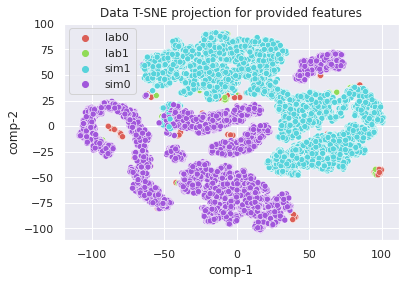

In [ ]:
from sklearn.manifold import TSNE

#  TSNE projects high-dimensional vectors to 2D space
tsne = TSNE(n_components=2, learning_rate="auto", init="random")

tf = tsne.fit_transform(raw_data1_norm) 
df = pd.DataFrame()
df["y"] = raw_data1_label
df["comp-1"] = tf[:,0]
df["comp-2"] = tf[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 4),
                data=df).set(title="Data T-SNE projection for provided features")

## for all features (provided + newly generated)

In [ ]:
# for the all features together

######################################################
# !!! Set your list of implemented features here !!! #
######################################################

FEATURE_LIST = [mean_step_speed, stddev_step_speed, track_length, e2e_distance, duration, mean_step_acc, stddev_step_acc, trajectory_slope, mean_angular_speed, stddev_angular_speed, pearson_coefficient, std_X, std_Y, linear_trend_error_mse, linear_trend_error_std]   # add newly generated features here 
TYPE = "train1"
# TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M%S")
TIMESTAMP = 0
OUTPUT_FILENAME = f"./{TYPE}_features_{TIMESTAMP}.csv"


######################################################
# You shouldn't have to modify the rest of this part #
######################################################

# Generate the feature csv
header = ['uid', 'label']
for featfunc in FEATURE_LIST:
    header.append(featfunc.__name__)

features = []

track1_uids = train1_data.keys()
for uid in track1_uids:
    curr_row = {
        'uid': uid,
        'label': train1_data[uid]['label']
    }
    
    for featfunc in FEATURE_LIST:
        curr_row[featfunc.__name__] = featfunc(np.array(train1_data[uid]['txy']))
    
    features.append(curr_row)

with open(OUTPUT_FILENAME, 'w') as f:
    writer = csv.DictWriter(f, fieldnames = header)
    writer.writeheader()
    for r in features:
        writer.writerow(r)

print("Written to:", OUTPUT_FILENAME)

/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',


Written to: ./train1_features_0.csv


In [ ]:
# reading data from csv file

raw_data1 = pd.read_csv("./train1_features_0.csv")
raw_data1.head()

,uid,label,mean_step_speed,stddev_step_speed,track_length,e2e_distance,duration,mean_step_acc,stddev_step_acc,trajectory_slope,mean_angular_speed,stddev_angular_speed,pearson_coefficient,std_X,std_Y,linear_trend_error_mse,linear_trend_error_std
0,lab_0_0,lab0,0.173088,0.100141,51.926349,40.408772,300.0,0.013448,0.056163,2.341707,0.615727,0.437738,0.957199,11.507870,3.969233,5.095612e+05,676.760899
1,lab_0_1,lab0,0.165048,0.086194,49.514298,32.957322,300.0,0.011272,0.039420,5.245669,0.732241,0.434840,0.963756,8.609742,4.938513,5.490758e+05,729.978430
2,lab_0_2,lab0,0.167388,0.099177,50.216438,31.649486,300.0,0.013750,0.049274,2.142723,0.624176,0.460002,0.952560,7.902758,4.619798,1.639389e+05,387.601293
3,lab_0_3,lab0,0.215927,0.109797,64.778077,42.524948,300.0,0.012994,0.048920,2.575218,0.602782,0.477723,0.938176,13.215181,4.842157,5.107199e+04,223.863145
4,lab_0_4,lab0,0.097786,0.096984,29.335788,1.616936,300.0,0.007007,0.038347,1.854094,0.688123,0.458728,0.641750,1.229990,1.520791,2.134388e+06,1367.270986


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

raw_data1 = raw_data1.dropna().reset_index(drop=True)
raw_data1 = raw_data1.drop(['uid'],axis=1)

SS =  StandardScaler()

raw_data1_label = raw_data1.pop('label').reset_index(drop=True)
raw_data1_norm = SS.fit_transform(raw_data1) 

## plot for all features

[Text(0.5, 1.0, 'Data T-SNE projection for all features')]

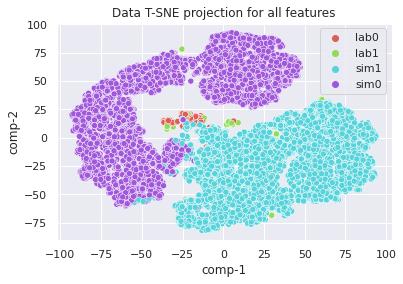

In [ ]:
from sklearn.manifold import TSNE

#  TSNE projects high-dimensional vectors to 2D space
tsne = TSNE(n_components=2, learning_rate="auto", init="random")

tf = tsne.fit_transform(raw_data1_norm) 
df = pd.DataFrame()
df["y"] = raw_data1_label
df["comp-1"] = tf[:,0]
df["comp-2"] = tf[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 4),
                data=df).set(title="Data T-SNE projection for all features")

# Feature Generation

In [ ]:
######################################################
# !!! Set your list of implemented features here !!! #
######################################################

FEATURE_LIST = [mean_step_speed, stddev_step_speed, track_length, e2e_distance, duration, mean_step_acc, stddev_step_acc, trajectory_slope, mean_angular_speed, stddev_angular_speed, pearson_coefficient, std_X, std_Y, linear_trend_error_mse, linear_trend_error_std]   # add newly generated features here 
TYPE = "train"
# TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M%S")
TIMESTAMP = 0
OUTPUT_FILENAME = f"./{TYPE}_allfeatures_{TIMESTAMP}.csv"


######################################################
# You shouldn't have to modify the rest of this part #
######################################################

# Generate the feature csv
header = ['uid', 'label']
for featfunc in FEATURE_LIST:
    header.append(featfunc.__name__)

features = []

track_uids = track_data.keys()
for uid in track_uids:
    curr_row = {
        'uid': uid,
        'label': track_data[uid]['label']
    }
    
    for featfunc in FEATURE_LIST:
        curr_row[featfunc.__name__] = featfunc(np.array(track_data[uid]['txy']))
    
    features.append(curr_row)

with open(OUTPUT_FILENAME, 'w') as f:
    writer = csv.DictWriter(f, fieldnames = header)
    writer.writeheader()
    for r in features:
        writer.writerow(r)

print("Written to:", OUTPUT_FILENAME)

/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',


Written to: ./train_allfeatures_0.csv


In [ ]:
raw_data = pd.read_csv("./train_allfeatures_0.csv")
raw_data.head()

,uid,label,mean_step_speed,stddev_step_speed,track_length,e2e_distance,duration,mean_step_acc,stddev_step_acc,trajectory_slope,mean_angular_speed,stddev_angular_speed,pearson_coefficient,std_X,std_Y,linear_trend_error_mse,linear_trend_error_std
0,lab_0_0,0,0.173088,0.100141,51.926349,40.408772,300.0,0.013448,0.056163,2.341707,0.615727,0.437738,0.957199,11.507870,3.969233,5.095612e+05,676.760899
1,lab_0_1,0,0.165048,0.086194,49.514298,32.957322,300.0,0.011272,0.039420,5.245669,0.732241,0.434840,0.963756,8.609742,4.938513,5.490758e+05,729.978430
2,lab_0_2,0,0.167388,0.099177,50.216438,31.649486,300.0,0.013750,0.049274,2.142723,0.624176,0.460002,0.952560,7.902758,4.619798,1.639389e+05,387.601293
3,lab_0_3,0,0.215927,0.109797,64.778077,42.524948,300.0,0.012994,0.048920,2.575218,0.602782,0.477723,0.938176,13.215181,4.842157,5.107199e+04,223.863145
4,lab_0_4,0,0.097786,0.096984,29.335788,1.616936,300.0,0.007007,0.038347,1.854094,0.688123,0.458728,0.641750,1.229990,1.520791,2.134388e+06,1367.270986


In [ ]:
raw_lab_data = raw_data[raw_data["uid"].str.contains("lab")]
raw_lab_data.describe()

,label,mean_step_speed,stddev_step_speed,track_length,e2e_distance,duration,mean_step_acc,stddev_step_acc,trajectory_slope,mean_angular_speed,stddev_angular_speed,pearson_coefficient,std_X,std_Y,linear_trend_error_mse,linear_trend_error_std
count,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000,3.680000e+02,368.000000,368.000000,364.000000,368.000000,368.000000,3.680000e+02,3.680000e+02
mean,0.285326,3.035777,0.968048,314.108579,266.759088,169.654891,0.351218,0.859348,1.748271e+09,0.707881,0.227654,0.837629,59.562179,47.948249,7.310980e+25,4.426234e+11
std,0.452184,3.201875,3.429552,310.622720,259.937234,108.684745,0.939983,4.727611,3.353765e+10,0.270379,0.178446,0.270474,60.586565,53.387759,1.402489e+27,8.490990e+12
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000e+00,0.044296,0.000000,0.027175,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,0.000000,0.766921,0.098242,56.254769,42.467854,62.750000,0.008120,0.039811,1.200093e-01,0.510241,0.071575,0.798917,9.498822,7.054410,1.758858e+04,4.972071e+01
50%,0.000000,2.030907,0.214559,227.133911,199.072613,157.500000,0.032264,0.137809,3.310679e-01,0.738524,0.164042,0.993216,42.515433,29.117860,1.634424e+05,1.482423e+02
75%,1.000000,4.449534,0.895806,459.894900,415.914945,299.000000,0.170809,0.533030,2.880976e+00,0.889550,0.392231,0.999177,92.115488,74.206778,1.507321e+06,9.837252e+02
max,1.000000,19.002323,49.447504,1541.141482,1190.597017,342.000000,10.986424,69.514673,6.433637e+11,1.570796,0.708593,1.000000,318.097989,296.304092,2.690441e+28,1.628854e+14


In [ ]:
raw_sim_data = raw_data[raw_data["uid"].str.contains("sim")]
raw_sim_data.describe()

,label,mean_step_speed,stddev_step_speed,track_length,e2e_distance,duration,mean_step_acc,stddev_step_acc,trajectory_slope,mean_angular_speed,stddev_angular_speed,pearson_coefficient,std_X,std_Y,linear_trend_error_mse,linear_trend_error_std
count,15712.000000,15645.000000,15645.000000,15712.000000,15712.000000,15712.000000,15645.000000,15645.000000,15645.000000,15645.000000,15645.000000,15606.000000,15712.000000,15712.000000,1.571200e+04,15645.000000
mean,0.497391,2.235101,0.980422,416.993282,285.077644,189.986253,0.774103,0.640808,64.296790,0.806538,0.477165,0.829249,59.668660,60.254570,1.213499e+09,24603.302726
std,0.500009,0.803359,0.462697,271.315907,168.397860,103.934585,0.147652,0.106197,30.659558,0.117526,0.062324,0.263860,39.392494,38.914824,2.766245e+09,21660.561252
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,0.000000,1.546087,0.571191,189.302141,142.109108,94.000000,0.670475,0.572132,44.682270,0.773128,0.462847,0.755033,28.054791,28.388246,8.947553e+07,9069.258658
50%,0.000000,1.638566,0.645535,422.236507,290.440178,207.000000,0.757299,0.635231,51.001623,0.809103,0.482474,0.989516,57.191410,58.472027,4.207859e+08,19551.332281
75%,1.000000,2.876983,1.420014,571.567027,420.733883,300.000000,0.889177,0.715907,84.431719,0.843121,0.506860,0.999298,86.036948,86.171022,1.263605e+09,33757.918063
max,1.000000,7.496901,2.647358,1275.010201,1121.750864,300.000000,2.000000,2.000000,265.884544,1.570796,0.785398,1.000000,276.603547,255.525855,7.794273e+10,249209.569045



---
---

# Best Performing ML Models

---
---



## Train and Test Split, Normalization, Weights for sample weighting

Drive Link for Data (train_allfeatures_0.csv) : https://drive.google.com/file/d/1rPd-X45ja2-k0c_iuub2I_aSxIgJWsoO/view?usp=sharing

In [ ]:
raw_data = pd.read_csv("./train_allfeatures_0.csv")
raw_data.head()

raw_data= raw_data.dropna().reset_index(drop=True)
raw_data["lab_stat"] = raw_data["uid"].str.contains("lab").astype(int)

strat = np.hstack((np.array(raw_data["label"]).reshape(-1,1), np.array(raw_data["lab_stat"]).reshape(-1,1)))


raw_data = raw_data.drop(['uid'],axis=1)

np.random.seed(0)

train, test = train_test_split(raw_data, test_size=0.2,stratify=strat,random_state=0)

ytrain= train.pop('label').reset_index(drop=True)
Xtrain = train.reset_index(drop=True)

ytest= test.pop('label').reset_index(drop=True)
Xtest = test.reset_index(drop=True)

In [ ]:
SS =  StandardScaler()
X_train_norm = SS.fit_transform(Xtrain)
X_test_norm = SS.transform(Xtest)

In [ ]:
X_train_norm[:,-1] = [1 if Xtrain['lab_stat'][i] == 1 else 0 for i in range(len(Xtrain))]
X_test_norm[:,-1] = [1 if Xtest['lab_stat'][i] == 1 else 0 for i in range(len(Xtest))]

samp_lab_ind = Xtrain['lab_stat']
Xtest = Xtest.drop(['lab_stat'],axis=1)

lab_weight = 45
weights = (lab_weight-1)*np.array(samp_lab_ind).reshape(-1,1)
weights = np.ones_like(weights) + weights

## SVM

In [ ]:
# SVM
param_grid= {'kernel': ('linear', 'rbf'),'C': [1, 10]}
svc = SVC(gamma='auto')
clf = GridSearchCV(svc, param_grid,cv=5)

clf.fit(X_train_norm, ytrain,sample_weight=weights.reshape(-1))
y_pred_test = clf.predict(X_test_norm)

fbeta_score(ytest, y_pred_test, beta=2)

0.9957870547682881

In [ ]:
clf.best_params_

{'C': 10, 'kernel': 'rbf'}

In [ ]:
# SVM

svc = SVC(gamma='auto',C=10,kernel='rbf')

svc.fit(X_train_norm, ytrain,sample_weight=weights.reshape(-1))
y_pred_test = svc.predict(X_test_norm)

fbeta_score(ytest, y_pred_test, beta=2)

0.9957870547682881

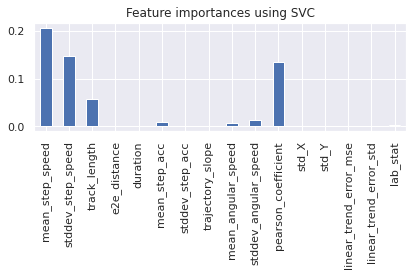

In [ ]:
perm_importance = permutation_importance(svc, X_test_norm, ytest)

feature_names = Xtest.columns
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()

forest_importances = pd.Series( perm_importance.importances_mean, index=np.array(Xtrain.columns))

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using SVC")
fig.tight_layout()

## Random Forest (on Normalized Data)

In [ ]:
n_estimators = 100

param_grid= {'min_samples_leaf':[5,10], 'max_depth':[5,10]}
rfc = RandomForestClassifier(n_estimators = n_estimators, criterion = 'gini',max_depth=10,min_samples_leaf=5)
clf_rf = GridSearchCV(rfc, param_grid,cv=5)

clf_rf.fit(X_train_norm, ytrain,sample_weight=weights.reshape(-1))
y_pred_test = clf_rf.predict(X_test_norm)

fbeta_score(ytest, y_pred_test, beta=2)

0.9975762214568185

In [ ]:
clf_rf.best_params_

{'max_depth': 10, 'min_samples_leaf': 5}

In [ ]:
n_estimators = 100

clf_rf = RandomForestClassifier(n_estimators = n_estimators, criterion = 'gini',max_depth=10,min_samples_leaf=5)

clf_rf.fit(X_train_norm, ytrain,sample_weight=weights.reshape(-1))
y_pred_test = clf_rf.predict(X_test_norm)

fbeta_score(ytest, y_pred_test, beta=2)

0.997192803368636

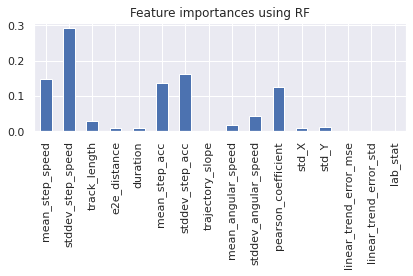

In [ ]:
forest_importances = pd.Series(clf_rf.feature_importances_, index=np.array(Xtrain.columns))

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using RF")
fig.tight_layout()

## Random Forest (on unnormalized Data)

In [ ]:
raw_data = pd.read_csv("./train_allfeatures_0.csv")
raw_data.head()

raw_data= raw_data.dropna().reset_index(drop=True)
raw_data["lab_stat"] = raw_data["uid"].str.contains("lab").astype(int)

strat = np.hstack((np.array(raw_data["label"]).reshape(-1,1), np.array(raw_data["lab_stat"]).reshape(-1,1)))

raw_data = raw_data.drop(['uid'],axis=1)

np.random.seed(0)

train, test = train_test_split(raw_data, test_size=0.2,stratify=strat,random_state=0)


ytrain= train.pop('label').reset_index(drop=True)
Xtrain = train.reset_index(drop=True)

ytest= test.pop('label').reset_index(drop=True)
Xtest = test.reset_index(drop=True)

In [ ]:
samp_lab_ind = Xtrain['lab_stat']
# Xtest = Xtest.drop(['lab_stat'],axis=1)

lab_weight = 45
weights = (lab_weight-1)*np.array(samp_lab_ind).reshape(-1,1)
weights = np.ones_like(weights) + weights

In [ ]:
n_estimators = 100

param_grid= {'min_samples_leaf':[5,10], 'max_depth':[5,10]}
rfc = RandomForestClassifier(n_estimators = n_estimators, criterion = 'gini')
clf_rf_2 = GridSearchCV(rfc, param_grid,cv=5)

clf_rf_2.fit(Xtrain, ytrain,sample_weight=weights.reshape(-1))
y_pred_test = clf_rf_2.predict(Xtest)

fbeta_score(ytest, y_pred_test, beta=2)

0.997192803368636

In [ ]:
clf_rf_2.best_params_

{'max_depth': 10, 'min_samples_leaf': 5}

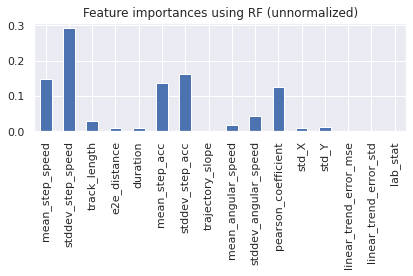

In [ ]:
forest_importances = pd.Series(clf_rf.feature_importances_, index=np.array(Xtrain.columns))

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using RF (unnormalized)")
fig.tight_layout()

## Adaboost with Decision Tree (with reduced features & on only Lab Data)

Drive Link for Data (train_reduced_features.csv) : https://drive.google.com/file/d/1WV_kNsarczjiU3fBQrgG9eTVagAlQeBK/view?usp=sharing

In [ ]:
raw_data = pd.read_csv("/content/train_reduced_features.csv")   # to avoid feature 
raw_data.head()

,uid,label,mean_step_speed,stddev_step_speed,track_length,e2e_distance,duration,mean_step_acc,stddev_step_acc,trajectory_slope,mean_angular_speed,stddev_angular_speed,pearson_coefficient
0,lab_0_0,0,0.173088,0.100141,51.926349,40.408772,300.0,0.013448,0.056163,0.784116,0.615727,0.437738,0.957199
1,lab_0_1,0,0.165048,0.086194,49.514298,32.957322,300.0,0.011272,0.039420,-0.931077,0.732241,0.434840,0.963756
2,lab_0_2,0,0.167388,0.099177,50.216438,31.649486,300.0,0.013750,0.049274,0.643860,0.624176,0.460002,0.952560
3,lab_0_3,0,0.215927,0.109797,64.778077,42.524948,300.0,0.012994,0.048920,0.387184,0.602782,0.477723,0.938176
4,lab_0_4,0,0.097786,0.096984,29.335788,1.616936,300.0,0.007007,0.038347,0.666405,0.688123,0.458728,0.641750


In [ ]:
# Decision Tree on reduced features 

raw_data = pd.read_csv("/content/train_reduced_features.csv")   # to avoid feature 
raw_data.head()

raw_data= raw_data.dropna().reset_index(drop=True)

raw_lab_data = raw_data[raw_data["uid"].str.contains("lab")]

In [ ]:
sim_ids = [raw_lab_data['uid'][i] for i in range(len(raw_lab_data)) if 'sim' in raw_lab_data['uid'][i]]
lab_ids = [raw_lab_data['uid'][i] for i in range(len(raw_lab_data)) if 'lab' in raw_lab_data['uid'][i]]

print(len(sim_ids),len(lab_ids))

0 364


In [ ]:
raw_lab_data["lab_stat"] = raw_lab_data["uid"].str.contains("lab").astype(int)
raw_lab_data = raw_lab_data.drop(['uid'],axis=1)

train, test = train_test_split(raw_lab_data, test_size=0.2,stratify=raw_lab_data['label'],random_state=0)

ytrain= train.pop('label').reset_index(drop=True)
Xtrain = train.reset_index(drop=True)

ytest= test.pop('label').reset_index(drop=True)
Xtest = test.reset_index(drop=True)

<ipython-input-73-dc2409caa6e2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_lab_data["lab_stat"] = raw_lab_data["uid"].str.contains("lab").astype(int)


In [ ]:
SS_2 = StandardScaler()
X_train_norm = SS_2.fit_transform(Xtrain)
X_test_norm = SS_2.transform(Xtest)

In [ ]:
X_train_norm[:,-1] = [1 if Xtrain['lab_stat'][i] == 1 else 0 for i in range(len(Xtrain))]
X_test_norm[:,-1] = [1 if Xtest['lab_stat'][i] == 1 else 0 for i in range(len(Xtest))]

Xtest = Xtest.drop(['lab_stat'],axis=1)

### Training and Validation

In [ ]:
# adaboost with decision tree

DT = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

parameters = {'base_estimator__max_depth':[i for i in range(2,11,2)],
              'base_estimator__min_samples_leaf':[5,10],
              'n_estimators':[10,50,250,1000],
              'learning_rate':[0.01,0.1]}

clf_ada_DT = GridSearchCV(DT, parameters,verbose=3,n_jobs=-1)

clf_ada_DT.fit(X_train_norm, ytrain)
y_pred_test = clf_ada_DT.predict(X_test_norm)

fbeta_score(ytest, y_pred_test, beta=2)

In [ ]:
clf_ada_DT.best_params_

In [ ]:
DT_max_depth = 6
DT_min_samples_leaf = 5
n_estimators = 50
learning_rate = 0.1

DT = DecisionTreeClassifier(max_depth=DT_max_depth, min_samples_leaf=DT_min_samples_leaf)

clf_ada_DT = AdaBoostClassifier(base_estimator=DT, n_estimators = n_estimators, learning_rate = learning_rate)

clf_ada_DT.fit(X_train_norm, ytrain)
y_pred_test = clf_ada_DT.predict(X_test_norm)

fbeta_score(ytest, y_pred_test, beta=2)

0.8878504672897196

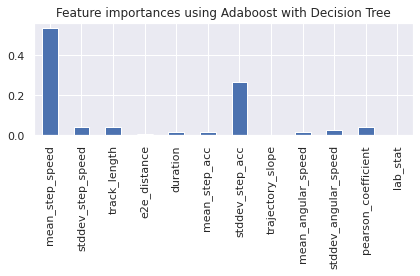

In [ ]:
forest_importances = pd.Series(clf_ada_DT.feature_importances_, index=np.array(Xtrain.columns))

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using Adaboost with Decision Tree")
fig.tight_layout()

# Ensemble of All Models

## Test on lab data 

### For normalized (SVM and RF)

In [ ]:
# all features

raw_data = pd.read_csv("./train_allfeatures_0.csv")
raw_data.head()

raw_data= raw_data.dropna().reset_index(drop=True)
raw_data["lab_stat"] = raw_data["uid"].str.contains("lab").astype(int)
raw_lab_data = raw_data[raw_data["uid"].str.contains("lab")]
raw_sim_data = raw_data[raw_data["uid"].str.contains("sim")]

raw_lab_data= raw_lab_data.dropna().reset_index(drop=True)
raw_lab_data = raw_lab_data.drop(['uid'],axis=1)

raw_sim_data= raw_sim_data.dropna().reset_index(drop=True)
raw_sim_data = raw_sim_data.drop(['uid'],axis=1)

ysim_label = raw_sim_data.pop('label').reset_index(drop=True)
Xsim = raw_sim_data.reset_index(drop=True)

ylab_label = raw_lab_data.pop('label').reset_index(drop=True)
Xlab = raw_lab_data.reset_index(drop=True)

X_lab_norm = SS.transform(Xlab)
X_sim_norm = SS.transform(Xsim)

X_lab_norm[:,-1] = [1 if Xlab['lab_stat'][i] == 1 else 0 for i in range(len(Xlab))]
X_sim_norm[:,-1] = [1 if Xsim['lab_stat'][i] == 1 else 0 for i in range(len(Xsim))]

In [ ]:
# reduced features

raw_data2 = pd.read_csv("./train_reduced_features.csv")
raw_data2.head()

raw_data2= raw_data2.dropna().reset_index(drop=True)
raw_data2["lab_stat"] = raw_data2["uid"].str.contains("lab").astype(int)
raw_lab_data2 = raw_data2[raw_data2["uid"].str.contains("lab")]
raw_sim_data2 = raw_data2[raw_data2["uid"].str.contains("sim")]

raw_lab_data2= raw_lab_data2.dropna().reset_index(drop=True)
raw_lab_data2 = raw_lab_data2.drop(['uid'],axis=1)

raw_sim_data2= raw_sim_data2.dropna().reset_index(drop=True)
raw_sim_data2 = raw_sim_data2.drop(['uid'],axis=1)

ysim_label2 = raw_sim_data2.pop('label').reset_index(drop=True)
Xsim2 = raw_sim_data2.reset_index(drop=True)

ylab_label2 = raw_lab_data2.pop('label').reset_index(drop=True)
Xlab2 = raw_lab_data2.reset_index(drop=True)

X_lab_norm_2 = SS_2.transform(Xlab2)
X_sim_norm_2 = SS_2.transform(Xsim2)

X_lab_norm_2[:,-1] = [1 if Xlab2['lab_stat'][i] == 1 else 0 for i in range(len(Xlab2))]
X_sim_norm_2[:,-1] = [1 if Xsim2['lab_stat'][i] == 1 else 0 for i in range(len(Xsim2))]

In [ ]:
# on lab data out of three classifier
y_pred_test_svc = clf.predict(X_lab_norm)
y_pred_test_ada = clf_ada_DT.predict(X_lab_norm_2)
y_pred_test_rbf = clf_rf.predict(X_lab_norm)

fbeta_score(ylab_label, np.maximum(y_pred_test_svc, y_pred_test_rbf,y_pred_test_ada), beta=2)

0.9732824427480916

In [ ]:
# un-normalized

raw_data = pd.read_csv("./train_allfeatures_0.csv")
raw_data.head()

raw_data= raw_data.dropna().reset_index(drop=True)
raw_data["lab_stat"] = raw_data["uid"].str.contains("lab").astype(int)

raw_lab_data = raw_data[raw_data["uid"].str.contains("lab")]
raw_sim_data = raw_data[raw_data["uid"].str.contains("sim")]

raw_lab_data= raw_lab_data.dropna().reset_index(drop=True)
raw_lab_data = raw_lab_data.drop(['uid'],axis=1)

raw_sim_data= raw_sim_data.dropna().reset_index(drop=True)
raw_sim_data = raw_sim_data.drop(['uid'],axis=1)

ysim_label = raw_sim_data.pop('label').reset_index(drop=True)
Xsim = raw_sim_data.reset_index(drop=True)

ylab_label = raw_lab_data.pop('label').reset_index(drop=True)
Xlab = raw_lab_data.reset_index(drop=True)

#Xlab[:,-1] = [1 if Xlab['lab_stat'][i] == 1 else 0 for i in range(len(Xlab))]
#Xsim[:,-1] = [1 if Xsim['lab_stat'][i] == 1 else 0 for i in range(len(Xsim))]

# X_lab_norm = SS.transform(Xlab)
# X_sim_norm = SS.transform(Xsim)

In [ ]:
y_pred_test_rbf2 = clf_rf_2.predict(Xlab)

In [ ]:
fbeta_score(ylab_label, np.maximum(y_pred_test_rbf2,np.maximum(y_pred_test_svc, y_pred_test_rbf,y_pred_test_ada)), beta=2)

0.9732824427480916

## Final test on Kaggle test data

In [ ]:
with open('./test.json', 'r') as f:
    track_data = json.load(f)

######################################################
# !!! Set your list of implemented features here !!! #
######################################################

FEATURE_LIST = [mean_step_speed, stddev_step_speed, track_length, e2e_distance, duration, mean_step_acc, stddev_step_acc, trajectory_slope, mean_angular_speed, stddev_angular_speed, pearson_coefficient, std_X, std_Y, linear_trend_error_mse, linear_trend_error_std]   # add newly generated features here 
TYPE = "test"
# TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M%S")
TIMESTAMP = 2
OUTPUT_FILENAME = f"./{TYPE}_finalfeatures_{TIMESTAMP}.csv"


######################################################
# You shouldn't have to modify the rest of this part #
######################################################

# Generate the feature csv
header = ['uid', 'label']
for featfunc in FEATURE_LIST:
    header.append(featfunc.__name__)

features = []

track_uids = track_data.keys()
for uid in track_uids:
    curr_row = {
        'uid': uid,
        'label': track_data[uid]['label']
    }
    
    for featfunc in FEATURE_LIST:
        curr_row[featfunc.__name__] = featfunc(np.array(track_data[uid]['txy']))
    
    features.append(curr_row)

with open(OUTPUT_FILENAME, 'w') as f:
    writer = csv.DictWriter(f, fieldnames = header)
    writer.writeheader()
    for r in features:
        writer.writerow(r)

print("Written to:", OUTPUT_FILENAME)

/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Written to: ./test_finalfeatures_2.csv


Drive Link for Data (test_finalfeatures_2.csv) : https://docs.google.com/spreadsheets/d/1IneVHC_475RXRGYpfjvOTB3niPZgWyPE0CFXVBEPW7c/edit?usp=sharing

In [ ]:
raw_test_data = pd.read_csv("./test_finalfeatures_2.csv")
raw_test_data.head()

raw_test_data["lab_stat"] = raw_test_data["uid"].str.contains("lab").astype(int)

X_fin_test = raw_test_data.drop(['label','uid'],axis=1)
X_fin_test = X_fin_test.fillna(0)
X_fin_test_norm = SS.transform(X_fin_test)

In [ ]:
X_fin_test_norm[:,-1] = [1 if raw_test_data['lab_stat'][i] == 1 else 0 for i in range(len(raw_test_data))]

In [ ]:
for col in X_fin_test.columns:  
    print(col)
    print(X_fin_test[col].isnull().sum())

mean_step_speed
0
stddev_step_speed
0
track_length
0
e2e_distance
0
duration
0
mean_step_acc
0
stddev_step_acc
0
trajectory_slope
0
mean_angular_speed
0
stddev_angular_speed
0
pearson_coefficient
0
std_X
0
std_Y
0
linear_trend_error_mse
0
linear_trend_error_std
0
lab_stat
0


In [ ]:

y_pred_fin_test_svc = clf.predict(X_fin_test_norm)
y_pred_fin_test_rf1 = clf_rf.predict(X_fin_test_norm)
y_pred_fin_test_rf2 = clf_rf_2.predict(X_fin_test)

y_comb3 = np.maximum(y_pred_fin_test_svc, y_pred_fin_test_rf1, y_pred_fin_test_rf2)

Drive Link for Data (train_reduced_features_kaggle.csv) : https://drive.google.com/file/d/1YgmR4ca8FWDwz14PAenSgWudoIBSNm4E/view?usp=sharing

In [ ]:
raw_test_data2 = pd.read_csv("./test_reduced_features_kaggle.csv")
raw_test_data2.head()

raw_test_data2["lab_stat"] = raw_test_data2["uid"].str.contains("lab").astype(int)

X_fin_test2 = raw_test_data2.drop(['label','uid'],axis=1)
X_fin_test2 = X_fin_test2.fillna(0)
X_fin_test2_norm = SS_2.transform(X_fin_test2)

In [ ]:
X_fin_test2_norm[:,-1] = [1 if raw_test_data2['lab_stat'][i] == 1 else 0 for i in range(len(raw_test_data2))]

In [ ]:
for col in X_fin_test2.columns:  
    print(col)
    print(X_fin_test2[col].isnull().sum())

mean_step_speed
0
stddev_step_speed
0
track_length
0
e2e_distance
0
duration
0
mean_step_acc
0
stddev_step_acc
0
trajectory_slope
0
mean_angular_speed
0
stddev_angular_speed
0
pearson_coefficient
0
lab_stat
0


In [ ]:
y_pred_fin_test_ada = clf_ada_DT.predict(X_fin_test2_norm)

In [ ]:
y_final_preds = np.maximum(y_pred_fin_test_ada,y_comb3)

In [ ]:
OUTPUT_FILENAME = f"predictions4kaggle.csv"
header = ['uid', 'label']

features = []

track_uids = track_data.keys()
for l,uid in enumerate(track_uids):
    curr_row = {
        'uid': uid,
        'label': y_final_preds[l]
    }
    
    features.append(curr_row)

with open(OUTPUT_FILENAME, 'w') as f:
    writer = csv.DictWriter(f, fieldnames = header)
    writer.writeheader()
    for r in features:
        writer.writerow(r)

print("Written to:", OUTPUT_FILENAME)

Written to: predictions4kaggle.csv


---
---
# DL Models
---
---

In [ ]:
# Ref: https://www.kaggle.com/code/rejpalcz/best-loss-function-for-f1-score-metric/notebook

xtrain = X_train_norm.astype("float32")
xtest = X_test_norm.astype("float32")
yt = ytrain.astype("float32")
yte = ytest.astype("float32")


def f2_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 5*p*r / (4*p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

model = Sequential()
model.add(Dense(5, input_dim=15, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss=f2_loss)
model.summary()

print("Fit model on training data")
history = model.fit(
    xtrain,
    yt,
    batch_size = 32,
    sample_weight=weights
   )

predictions = K.round(model.predict(xtest))
print(predictions)
fbeta_score(ytest, predictions, beta=2)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 5)                 80        
                                                                 
 dense_7 (Dense)             (None, 10)                60        
                                                                 
 dense_8 (Dense)             (None, 1)                 11        
                                                                 
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________
Fit model on training data
100/100 [==============================] - 0s 2ms/step
tf.Tensor(
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [1.]
 [1.]], shape=(3194, 1), dtype=float32)


0.9886291850915981

# Stacked BiLSTM

A stateless, stacked and bidirectional LSTM (Long Short Term Memory) RNN Model is considered. 

## DataLoader Definitions

To not compromise with efficiency vectorized batching of sequences is done. To not compromise with performance and avoid high noise (due to highly variable sequence lengths) Bucket Data Sampler is used rather than padding.

In [ ]:
class BucketDataset(Dataset):

    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        if self.targets is None:
            return self.inputs[index]
        else:
            return self.inputs[index], self.targets[index]


class BucketBatchSampler(Sampler):
    # want inputs to be an array
    def __init__(self, inputs, batch_size):
        self.batch_size = batch_size
        ind_n_len = []
        for i, p in enumerate(inputs):
            ind_n_len.append((i, p.shape[0]))
        self.ind_n_len = ind_n_len
        self.batch_list = self._generate_batch_map()
        self.num_batches = len(self.batch_list)

    def _generate_batch_map(self):
        # shuffle all of the indices first so they are put into buckets differently
        shuffle(self.ind_n_len)
        # Organize lengths, e.g., batch_map[10] = [30, 124, 203, ...] <= indices of sequences of length 10
        batch_map = OrderedDict()
        for idx, length in self.ind_n_len:
            if length not in batch_map:
                batch_map[length] = [idx]
            else:
                batch_map[length].append(idx)
        # Use batch_map to split indices into batches of equal size
        # e.g., for batch_size=3, batch_list = [[23,45,47], [49,50,62], [63,65,66], ...]
        batch_list = []
        for length, indices in batch_map.items():
            for group in [indices[i:(i + self.batch_size)] for i in range(0, len(indices), self.batch_size)]:
                batch_list.append(group)
        return batch_list

    def batch_count(self):
        return self.num_batches

    def __len__(self):
        return len(self.ind_n_len)

    def __iter__(self):
        self.batch_list = self._generate_batch_map()
        # shuffle all the batches so they arent ordered by bucket size
        shuffle(self.batch_list)
        for i in self.batch_list:
            yield i

## Data Preparation

In [ ]:
raw_data = []
labels = []
lab_ind = []

for k,v in track_data.items():

    temp = np.array(v["txy"])
    raw_data.append(temp[:,1:])
    labels.append(v["label"])
    if "lab" in k:
      lab_ind.append(1)
    else:
      lab_ind.append(0)

In [ ]:
combined_ind = np.hstack((np.array(labels).reshape(-1,1),np.array(lab_ind).reshape(-1,1)))

In [ ]:
train_seq, temp_test, train_y, temp_test_y = train_test_split(raw_data, combined_ind, test_size=0.3, random_state=42, stratify=combined_ind)
val_seq, test_seq, val_y, test_y = train_test_split(temp_test, temp_test_y, test_size=0.3, random_state=42, stratify=temp_test_y)

In [ ]:
merged_train = np.empty((0,2))

for seq in train_seq:
    merged_train =np.vstack((merged_train,seq))


In [ ]:
scaler = StandardScaler()
scaler.fit(merged_train)

StandardScaler()

In [ ]:
norm_train_seq = []

for seq in train_seq:
    norm_train_seq.append(scaler.transform(seq))

norm_val_seq = []

for seq in val_seq:
    norm_val_seq.append(scaler.transform(seq))


norm_test_seq = []

for seq in test_seq:
    norm_test_seq.append(scaler.transform(seq))

In [ ]:
bucket_batch_sampler_train = BucketBatchSampler(norm_train_seq, 64) # <-- does not store X
bucket_dataset_train = BucketDataset(norm_train_seq, train_y)
train_dataloader = DataLoader(bucket_dataset_train, batch_size=1, batch_sampler=bucket_batch_sampler_train, shuffle=False, drop_last=False)


bucket_batch_sampler_val = BucketBatchSampler(norm_val_seq, 64) # <-- does not store X
bucket_dataset_val = BucketDataset(norm_val_seq, val_y)
val_dataloader = DataLoader(bucket_dataset_val, batch_size=1, batch_sampler=bucket_batch_sampler_val, shuffle=False, drop_last=False)


bucket_batch_sampler_test = BucketBatchSampler(norm_test_seq, 64) # <-- does not store X
bucket_dataset_test = BucketDataset(norm_test_seq, test_y)
test_dataloader = DataLoader(bucket_dataset_test, batch_size=1, batch_sampler=bucket_batch_sampler_test, shuffle=False, drop_last=False)

## Model Definition

In [ ]:
class BiLSTM_LifeSearch2(nn.Module):

    def __init__(self,input_dim,hidden_dim, n_lstm_layers=1, fc_dim=128, dropout = 0.5):

        super().__init__()

        self.lstm = nn.LSTM(input_dim,hidden_dim, n_lstm_layers, batch_first=True, bidirectional=True, dropout=dropout)
        self.clf_block1 = nn.Sequential(
        nn.Linear(2*hidden_dim,fc_dim),
        nn.ReLU())

        self.clf_block2 = nn.Sequential(
        nn.Linear(fc_dim,1),
        nn.Sigmoid()
        )

    def forward(self,x):

        out, hidden = self.lstm(x)
        out = self.clf_block1(out[:, -1, :])
        final_out = self.clf_block2(out)
        
        return final_out

In [ ]:
model = BiLSTM_LifeSearch2(input_dim=2,hidden_dim=64, n_lstm_layers=2,fc_dim=64)
model = model.cuda()

## Optimizer, Loss Function and Other Details

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.BCELoss(reduction='none')

## Main

In [ ]:
n_epochs = 1000
best_val_score = 0
patience, trials = 100, 0
lab_val=45

for epoch in range(n_epochs):
    
    for i, (x_batch, y_batch) in enumerate(train_dataloader):
        model.train()
        x_batch = x_batch.float().cuda()

        y_batch,lab_weight = y_batch[:,0].float().cuda(), y_batch[:,1].numpy().reshape(-1,1)

        weight = torch.FloatTensor(np.ones_like(lab_weight) + (lab_val-1)*lab_weight).cuda()

        optimizer.zero_grad()
        out = model(x_batch)
        loss = loss_fn(out, y_batch.view(-1,1))
        w_loss = torch.mean(weight*loss)
        w_loss.backward()
        optimizer.step()
    
    model.eval()
    # Turning off automatic differentiation
    with torch.no_grad():
        pred_list, true_list = [], []
        for x_val, y_val in val_dataloader:
            x_val, y_val = [t.float().cuda() for t in (x_val, y_val[:,0])]
            out = model(x_val)
            preds = out > 0.5
            preds = preds.view(-1)
            # print(out)
            pred_list += [preds[i].item() for i in range(preds.size(0))]
            true_list += [y_val[i].item() for i in range(y_val.size(0))]
    
    # print(np.mean(pred_list))
    score = fbeta_score(true_list,pred_list,beta=2)

    if epoch % 5 == 0:
        print(f'Epoch: {epoch:3d}. Loss: {w_loss.item():.4f}. Score.: {score:2.2%}')

    if score > best_val_score:
        trials = 0
        best_val_score = score
        torch.save(model.state_dict(), 'best.pth')
        print(f'Epoch {epoch} best model saved with F2 Score: {best_val_score:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break





Epoch:   0. Loss: 0.0040. Score.: 95.46%
Epoch 0 best model saved with F2 Score: 95.46%
Epoch 1 best model saved with F2 Score: 96.18%
Epoch:   5. Loss: 0.0004. Score.: 95.66%
Epoch:  10. Loss: 0.0046. Score.: 96.01%
Epoch 12 best model saved with F2 Score: 96.33%
Epoch 13 best model saved with F2 Score: 96.41%
Epoch:  15. Loss: 0.0351. Score.: 95.97%
Epoch:  20. Loss: 0.0445. Score.: 96.19%
Epoch 21 best model saved with F2 Score: 96.42%
Epoch 24 best model saved with F2 Score: 96.49%
Epoch:  25. Loss: 0.0000. Score.: 95.89%
Epoch:  30. Loss: 0.1916. Score.: 95.41%
Epoch:  35. Loss: 0.0565. Score.: 95.59%
Epoch 36 best model saved with F2 Score: 96.73%
Epoch:  40. Loss: 0.0939. Score.: 96.23%
Epoch 43 best model saved with F2 Score: 96.74%
Epoch:  45. Loss: 0.0002. Score.: 95.51%
Epoch:  50. Loss: 0.0002. Score.: 95.86%
Epoch:  55. Loss: 0.0000. Score.: 96.31%
Epoch:  60. Loss: 0.0014. Score.: 95.43%
Epoch:  65. Loss: 0.0010. Score.: 95.34%
Epoch:  70. Loss: 0.0058. Score.: 96.20%
Epo

KeyboardInterrupt: ignored

In [ ]:
model.load_state_dict(torch.load('best.pth'))
model.eval()
with torch.no_grad():
    pred_list, true_list = [],[]
    for x_test, y_test in test_dataloader:
        x_test, y_test = [t.float().cuda() for t in (x_test, y_test[:,0])]
        out = model(x_test)
        preds = out > 0.5
        preds = preds.view(-1)
        pred_list += [preds[i].item() for i in range(preds.size(0))]
        true_list += [y_test[i].item() for i in range(y_test.size(0))]

test_score = fbeta_score(true_list,pred_list,beta=2)

print("Final Test Score : ",test_score)

Final Test Score :  0.9754738015607579


## Lab and Sim Data

In [ ]:
lab_uids = [x for x in track_data.keys() if 'lab' in x]
sim_uids = [x for x in track_data.keys() if 'sim' in x]

In [ ]:
lab_raw_data = []
lab_labels = []

sim_raw_data = []
sim_labels = []

for k,v in track_data.items():

    if k in lab_uids:
        temp = np.array(v["txy"])
        lab_raw_data.append(temp[:,1:])
        lab_labels.append(v["label"])

    else:
        temp = np.array(v["txy"])
        sim_raw_data.append(temp[:,1:])
        sim_labels.append(v["label"])

In [ ]:
norm_lab_train_seq_check = []

for seq in lab_raw_data:
    norm_lab_train_seq_check.append(scaler.transform(seq))

norm_sim_train_seq_check = []

for seq in sim_raw_data:
    norm_sim_train_seq_check.append(scaler.transform(seq))

In [ ]:
model.eval()
with torch.no_grad():
    pred_list, true_list = [],[]
    for x, y in zip(norm_lab_train_seq_check,lab_labels):
        x,y= torch.FloatTensor(x), torch.FloatTensor([y])
        x,y = x.cuda(), y.cuda()
        x = x.unsqueeze(0)
        out = model(x)
        pred = out > 0.5
        pred_list.append(int(pred))
        true_list.append(int(y))

test_score = fbeta_score(true_list,pred_list,beta=2)

print("Final Score : ",test_score)

Final Score :  0.9166666666666666


In [ ]:
model.eval()
with torch.no_grad():
    pred_list, true_list = [],[]
    for x, y in zip(norm_sim_train_seq_check,sim_labels):
        x,y= torch.FloatTensor(x), torch.FloatTensor([y])
        x,y = x.cuda(), y.cuda()
        x = x.unsqueeze(0)
        out = model(x)
        pred = out > 0.5
        pred_list.append(int(pred))
        true_list.append(int(y))

test_score = fbeta_score(true_list,pred_list,beta=2)

print("Final Score : ",test_score)

Final Score :  0.9753314357514681
